In [1]:
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition/data")

Skipping, found downloaded files in "./epileptic-seizure-recognition" (use force=True to force download)


In [4]:
import pandas as pd

df = pd.read_csv("epileptic-seizure-recognition/Epileptic Seizure Recognition.csv")

In [5]:
!pip install mne

Defaulting to user installation because normal site-packages is not writeable


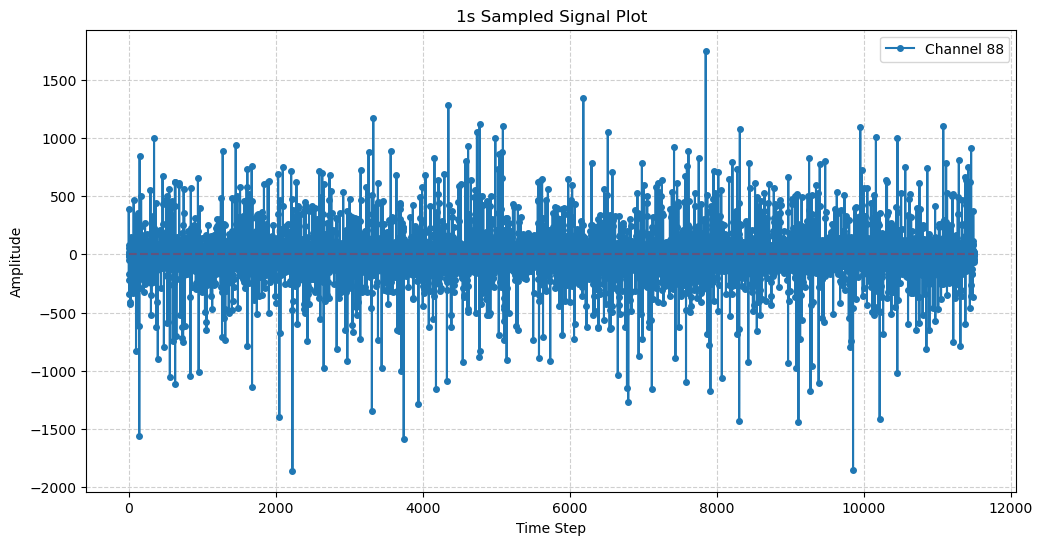

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import mne

eeg_data = df.iloc[:, :-1].select_dtypes(include='number').to_numpy().T

random_index = np.random.randint(eeg_data.shape[0])
signal = eeg_data[random_index, :]

plt.figure(figsize=(12, 6))
plt.plot(
    np.arange(len(signal)),
    signal,
    marker="o",
    linestyle="-",
    markersize=4,
    label=f"Channel {random_index + 1}",
)

plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.title("1s Sampled Signal Plot")
plt.hlines(0, 0, len(signal), linestyles="dashed", colors="r", alpha=0.3)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


In [9]:
df_numeric = df.select_dtypes(include='number')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
eeg_data_scaled = scaler.fit_transform(df_numeric.iloc[:, :-1])  # exclude label column
labels = df_numeric.iloc[:, -1].values


In [10]:
def create_windows(data, labels, window_size, step_size):
    X, y = [], []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        X.append(data[start:end])
        y.append(int(labels[start:end].mean() > 0.5))  # 1 if mostly seizure in window
    return np.array(X), np.array(y)

window_size = 256 * 2  # 2 seconds
step_size = 256        # 1 second overlap
X, y = create_windows(eeg_data_scaled, labels, window_size, step_size)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_flat = X.reshape(X.shape[0], -1)  # Flatten for classic ML
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [13]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.0/277.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 43.6 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 26.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 36.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 14.1 MB/s eta 0:00:00
 

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)


2025-03-21 11:22:15.795682: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-21 11:22:15.801406: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-21 11:22:15.815718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742570535.833759  178418 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742570535.841497  178418 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742570535.858071  178418 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/10


/ihome/cs1671_2025s/vad50/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-21 11:22:23.512805: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.8199 - loss: 0.4176 - val_accuracy: 1.0000 - val_loss: 2.0116e-17
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 7.8069e-17 - val_accuracy: 1.0000 - val_loss: 6.6378e-27
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 9.7328e-19 - val_accuracy: 1.0000 - val_loss: 7.3058e-34
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 2.3709e-33 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 5.5696e-37 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0000e

/ihome/cs1671_2025s/vad50/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


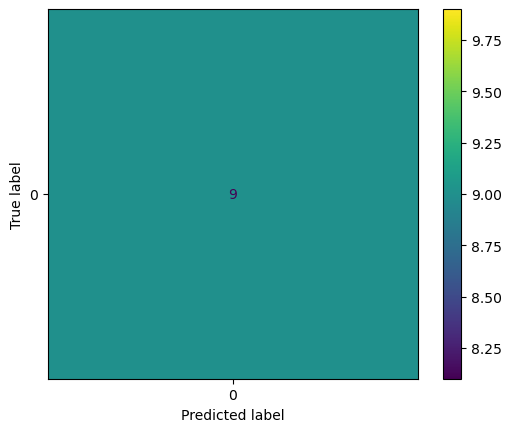

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


In [16]:
print(np.bincount(y_train))


[ 0 34]


In [18]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.2 MB/s eta 0:00:00:00:01


In [20]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(np.unique(y_pred, return_counts=True))
print(np.bincount(y_train))


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined